# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

**TL:DR**: respect to the original Jeremy's notebook I've added the following topics:
+ **INPUT DATA**: I've created clusters of different size and shuffled the rows in order to make it more realistic
+ **REPEATABLE MEANSHIFT (V1)**: I've pointed out that actual implementation has some randomness and I've reimplemented it in torch avoiding that issue and squeezing a bit of performance.
+ **SPARSE MEANSHIFT**: I've implemented a max distance treshold to prune out some points and sparsely compute the gaussian, but.. It turns out to be slower than the previous one.
+ **HACKY MEANSHIFT (V2)**: I've tried to leverage the fact that we're using the distances only to compute gaussian function and avoid to compute sqrt (on distance) and sqare (on gaussian); it turns out not to be slower.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters=6
n_samples=[250,300,75,125,500,400] # this is needed to have clusters of different size
assert n_clusters==len(n_samples)

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate random points around it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m,n_samples): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [7]:
# Compute data and labels
slices,labels = zip(*[(sample(c,s),torch.tensor([label]*s)) for label,(c,s) in enumerate(zip(centroids,n_samples))])
data = torch.cat(slices)
labels = torch.cat(labels)
data.shape, labels.shape

(torch.Size([1650, 2]), torch.Size([1650]))

**NOTE**: we randomize the rows in order to simulate real data: usually we don't know labels and X values are not ordered by label.

In [8]:
random_idx = torch.randperm(len(data))
data = data[random_idx]
labels=  labels[random_idx]

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [9]:
def plot_data(centroids, data, labels, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,(c,s) in enumerate(zip(centroids,labels.unique())):
        samples = data[labels==s]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*c, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*c, markersize=5, marker="x", color='m', mew=2)

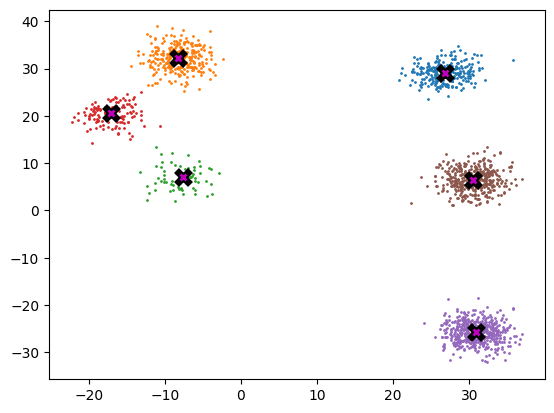

In [10]:
plot_data(centroids, data, labels)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [11]:
midp = data.mean(0)
midp

tensor([17.655,  5.882])

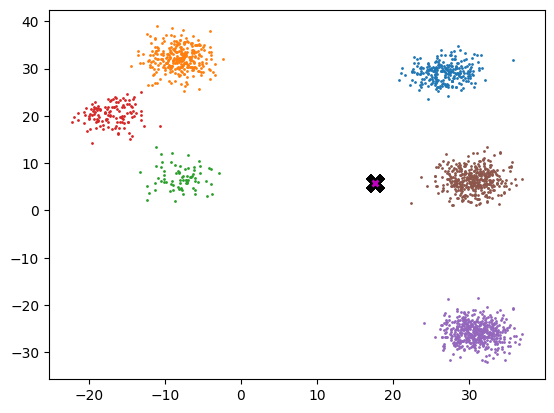

In [12]:
plot_data([midp]*6, data, labels)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [13]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [14]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

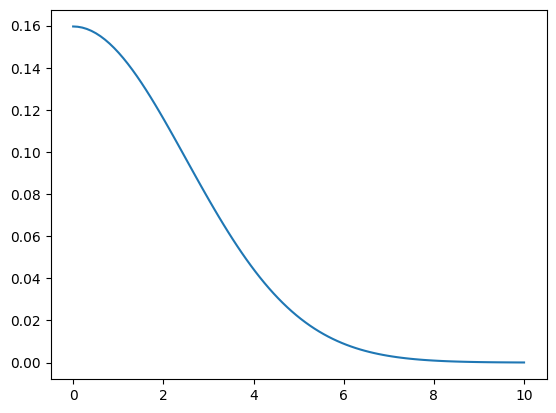

In [15]:
plot_func(partial(gaussian, bw=2.5))

In [16]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [17]:
def tri(d, i): return (-d+i).clamp_min(0)/i

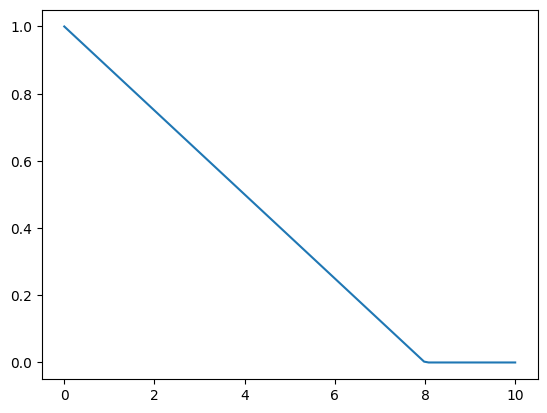

In [18]:
plot_func(partial(tri, i=8))

In [19]:
X = data.clone()
x = data[0]

In [20]:
x

tensor([ 30.967, -25.633])

In [21]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1650, 2]), torch.Size([1, 2]))

In [22]:
(x[None]-X)[:8]

tensor([[  0.000,   0.000],
        [ 40.092, -58.944],
        [ 35.004, -55.374],
        [ 40.775, -56.922],
        [  5.803, -55.174],
        [ 47.157, -41.799],
        [ -2.138,   0.325],
        [  0.272,  -0.374]])

In [23]:
(x-X)[:8]

tensor([[  0.000,   0.000],
        [ 40.092, -58.944],
        [ 35.004, -55.374],
        [ 40.775, -56.922],
        [  5.803, -55.174],
        [ 47.157, -41.799],
        [ -2.138,   0.325],
        [  0.272,  -0.374]])

In [24]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([ 0.000, 71.286, 65.510, 70.019, 55.479, 63.015,  2.163,  0.462])

In [25]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.000,     0.000,  ...,     0.000,     0.000,     0.000])

Let's take a look at how the distances repect to the first point are distributed:

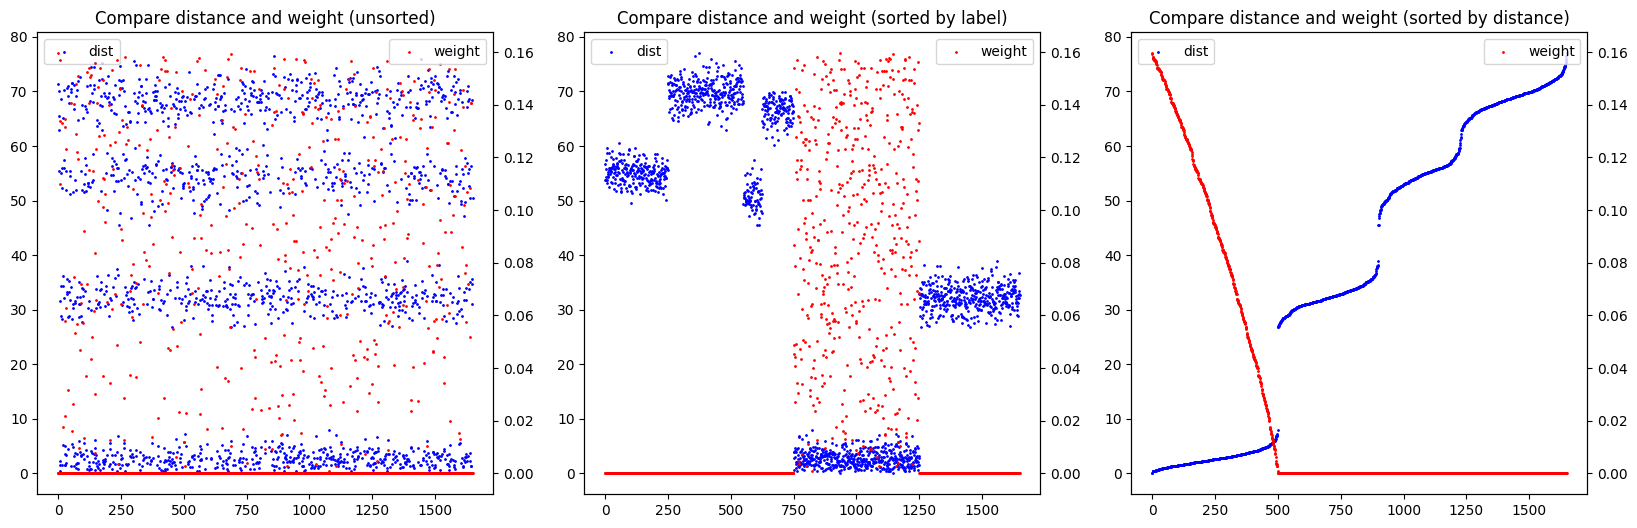

In [26]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.scatter(range(len(weight)),dist,color='b',s=1,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight,color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (unsorted)')

plt.subplot(1,3,2)
plt.scatter(range(len(weight)),dist[labels.argsort()],color='b',s=1,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[labels.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by label)')

plt.subplot(1,3,3)
plt.scatter(range(len(weight)),dist[dist.argsort()],color='b',s=1,label='dist')
#plt.ylabel('dist')
plt.legend(loc='upper left')
plt.gca().twinx().scatter(range(len(weight)),weight[dist.argsort()],color='r',s=1,label='weight')
#plt.ylabel('weight')
plt.legend(loc='upper right')
plt.title('Compare distance and weight (sorted by distance)');

As we can see the "weights" are almost zero above a certain distance.

In [27]:
weight.shape,X.shape

(torch.Size([1650]), torch.Size([1650, 2]))

In [28]:
weight[:,None].shape

torch.Size([1650, 1])

In [29]:
weight[:,None]*X

tensor([[     4.942,     -4.090],
        [    -0.000,      0.000],
        [    -0.000,      0.000],
        ...,
        [     0.000,      0.000],
        [    -0.000,      0.000],
        [    -0.000,      0.000]])

In [30]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
#         weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [31]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [32]:
%time X=meanshift(data)

CPU times: user 379 ms, sys: 0 ns, total: 379 ms
Wall time: 379 ms


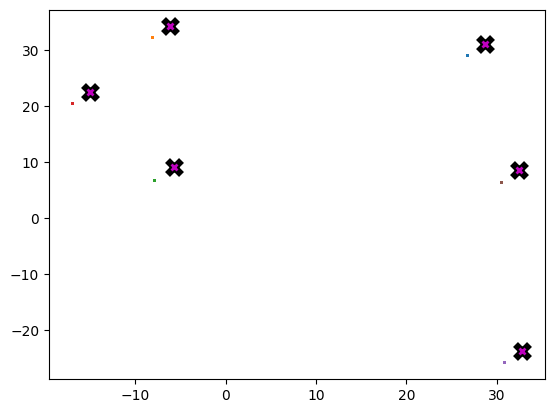

In [33]:
plot_data(centroids+2, X, labels)

## Animation

In [34]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [35]:
def do_one(d):
    if not d: return plot_data(centroids+2, X, labels, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, labels, ax=ax)

In [36]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [37]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1650, 2]))

In [38]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [39]:
dist_b(X, x)

tensor([[ 0.000, 71.286, 65.510,  ..., 30.996, 68.346, 50.494],
        [71.286,  0.000,  6.216,  ..., 46.777, 17.208, 24.934],
        [65.510,  6.216,  0.000,  ..., 40.565, 18.698, 21.303],
        [70.019,  2.134,  5.975,  ..., 46.154, 15.226, 23.025],
        [55.479, 34.496, 29.202,  ..., 24.495, 46.137, 37.741]])

In [40]:
dist_b(X, x).shape

torch.Size([5, 1650])

In [41]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1650, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1650, 2]))

In [42]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.000,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.199,     0.002,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.002,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.113,     0.002,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.000,  ...,     0.000,     0.000,     0.000]])

In [43]:
weight.shape,X.shape

(torch.Size([5, 1650]), torch.Size([1650, 2]))

In [44]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1650, 1]), torch.Size([1, 1650, 2]))

In [45]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [46]:
num

tensor([[ 1417.752, -1179.349],
        [ -194.279,   741.565],
        [  -44.391,   229.909],
        [ -190.077,   668.267],
        [  511.569,   582.124]])

In [47]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[ 1417.752, -1179.349],
        [ -194.279,   741.565],
        [  -44.391,   229.909],
        [ -190.077,   668.267],
        [  511.569,   582.124]])

In [48]:
weight@X

tensor([[ 1417.752, -1179.349],
        [ -194.279,   741.565],
        [  -44.391,   229.909],
        [ -190.077,   668.267],
        [  511.569,   582.124]])

In [49]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [50]:
num/div

tensor([[ 30.896, -25.701],
        [ -8.592,  32.795],
        [ -5.921,  30.664],
        [ -9.003,  31.654],
        [ 25.769,  29.323]])

In [51]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div # WARNING: we're modifying X 
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

**NOTE**: We're modifying X on each batch. This means that the second batch will see a different X.
This is fine from the point of view of convergence, but the result will depends on the order of data.
In other words shuffling data or changing batch size will lead to slightly different result.

Text(0.5, 1.0, 'Different batch sizes leads to different results')

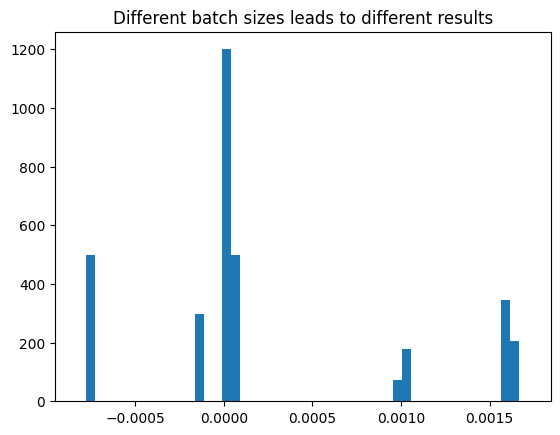

In [52]:
#torch.testing.assert_close( meanshift(data,bs=500) , meanshift(data,bs=500-1) ) # this does not pass
plt.hist(( meanshift(data,bs=500) - meanshift(data,bs=500-1) ).cpu().ravel(), bins=50);
plt.title('Different batch sizes leads to different results')

As we can see, vast majority of points has no deviation, but we have some of them that deviates a bit due to the randomness introduced by different batch size.

In [53]:
data = data.cuda()

In [54]:
X = meanshift(data).cpu()

In [55]:
%timeit -n 5 _=meanshift(data).cpu()

2.27 ms ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


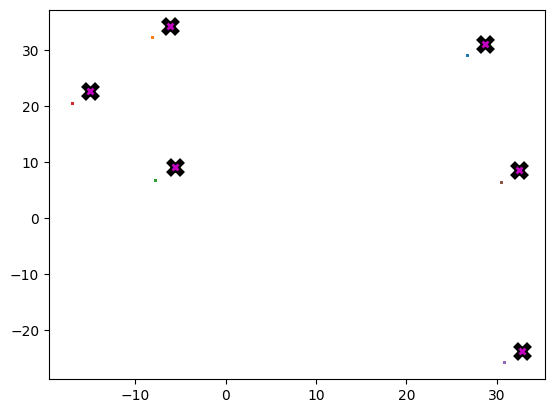

In [56]:
plot_data(centroids+2, X, labels)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

## Reimplementing meanshift in torch

In [57]:
data.is_cuda

True

In [58]:
# Restarting from scratch
X = data.clone()
X.shape

torch.Size([1650, 2])

In [59]:
# Settings
bs = 500
b = X[:bs,:]
b.shape

torch.Size([500, 2])

In [60]:
# Take diff
D = X[None,:,:] - b[:,None,:] 
D.shape

torch.Size([500, 1650, 2])

In [61]:
# Distances as L2 norm of diff
dists = torch.linalg.norm(D,axis=2)

In [62]:
# Gaussain
weights = gaussian(dists, 2.5)

tensor(False) tensor(True)
tensor(False) tensor(True)
tensor(False) tensor(True)


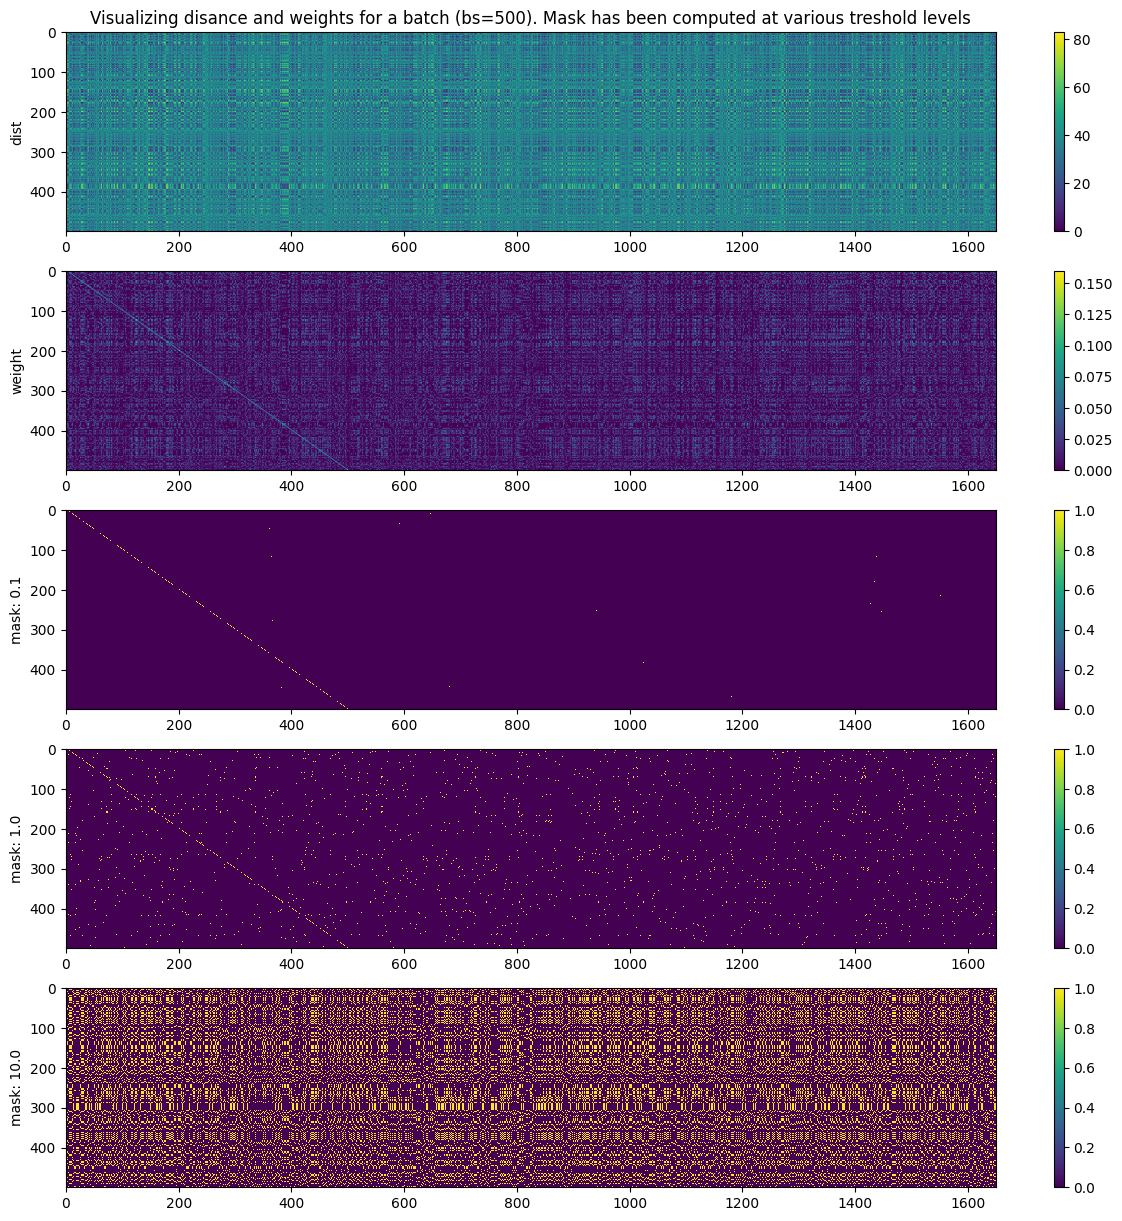

In [63]:
def plot_dists_and_weights(dists,weights):
    plt.figure(figsize=(15,15))
    d_tresholds = [1e-1, 1e0, 1e1]
    rows = 2+len(d_tresholds)
    plt.subplot(rows,1,1); plt.imshow(dists,aspect='auto'); plt.colorbar(); plt.ylabel('dist')
    plt.title(f'Visualizing disance and weights for a batch (bs={len(b)}). Mask has been computed at various treshold levels')
    plt.subplot(rows,1,2); plt.imshow(weights,aspect='auto'); plt.colorbar(); plt.ylabel('weight')

    for i,d_max in enumerate(d_tresholds):
        mask = (dists<d_max)
        print(mask.min(),mask.max())
        plt.subplot(rows,1,2+i+1); plt.imshow(mask,aspect='auto',interpolation='nearest'); plt.colorbar(); 
        plt.ylabel(f'mask: {d_max}')
        
plot_dists_and_weights(dists.cpu(),weights.cpu())

**NOTE**: that thin white line at -45 degree is there because we're **comparing a point with itself**.

We'll plot the same stuff sorting by distance and label to better show the effect of masking.

tensor(False) tensor(True)
tensor(False) tensor(True)
tensor(False) tensor(True)


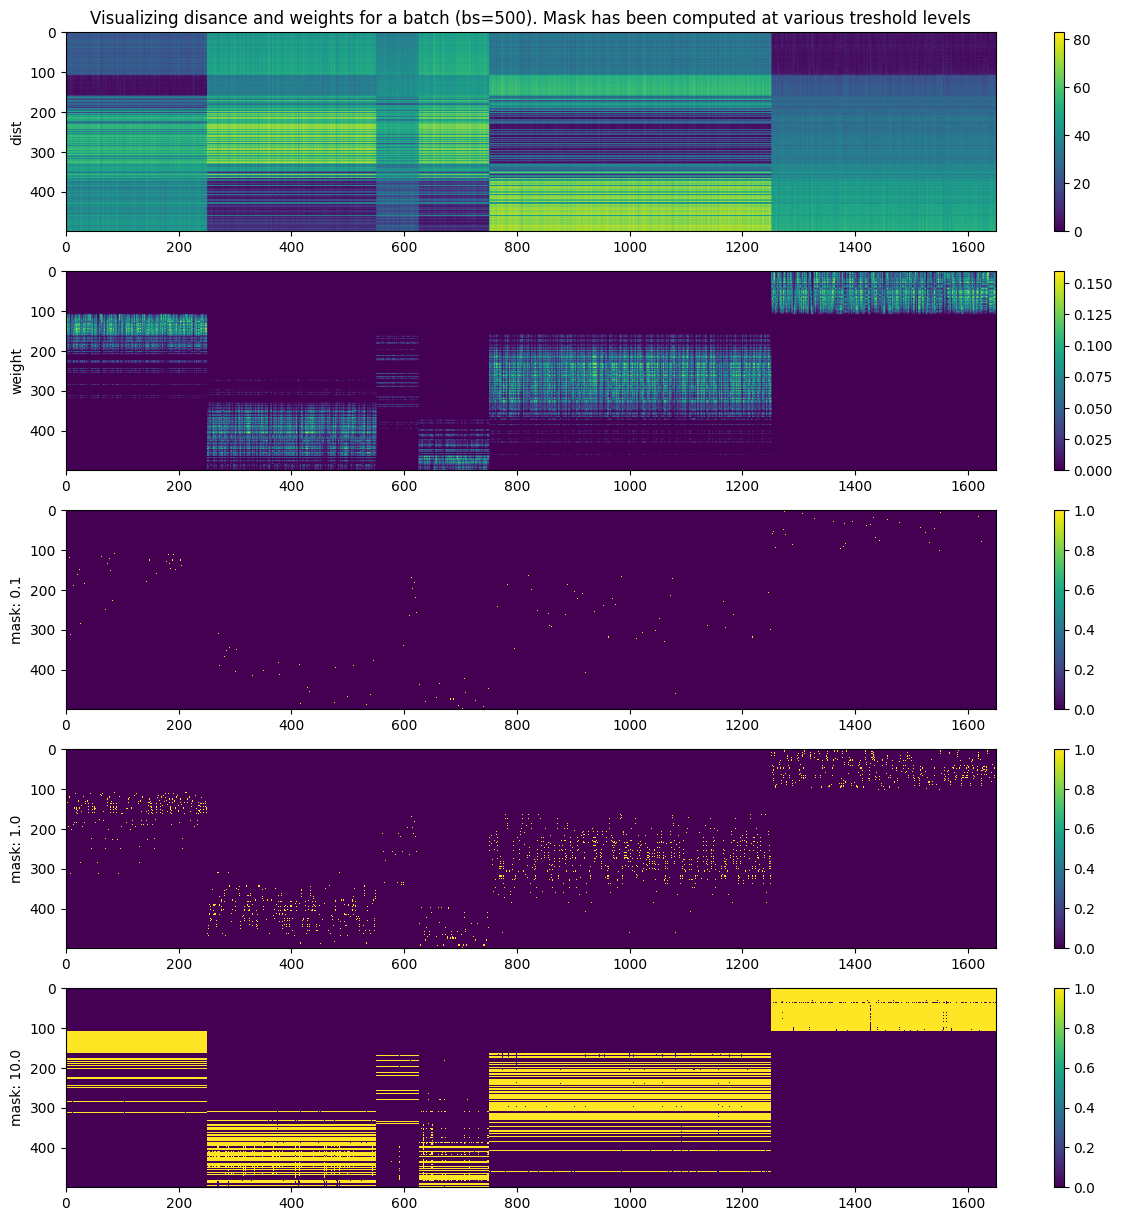

In [64]:
sorted_batch_idx = dists.sum(1).argsort()
sorted_label_idx = labels.argsort().cpu()
plot_dists_and_weights(dists.cpu()[sorted_batch_idx][:,sorted_label_idx],weights.cpu()[sorted_batch_idx][:,sorted_label_idx])

There are a lot of "zeros": we should try to understand if avoiding to compute on zero values leads to any improvement or **if it's more efficient to waste computation on GPU than trying to minimize it**. 

In [65]:
def batch_meanshift_step(b,X,bw=2.5):
    D = X[None,:,:] - b[:,None,:] # differences
    dists = torch.linalg.norm(D,axis=2)
    weights = gaussian(dists, bw=bw)
    #print(dists.shape,weights.shape)
    div = weights.sum(1, keepdim=True) # batchwise sum of weights
    return weights@X/div # weighted average
    
batch_meanshift_step(b,data.clone()).shape

torch.Size([500, 2])

In [66]:
%timeit -n 1000 batch_meanshift_step(b,data)

97.3 µs ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Try to make it faster using sparse compute and leveraging the fact that we have lot of zeros.

In [67]:
def batch_meanshift_step_d_max(b,X,d_max,bw=2.5):
    D = X[None,:,:] - b[:,None,:] # differences
    dists = torch.linalg.norm(D,axis=2)
    # convert to sparse
    mask = dists<=d_max 
    dists_ravel = dists[mask] # this returns a one dimensional array
    weights_ravel = gaussian(dists_ravel, bw=bw) # compute sparse gaussian 
    weights = torch.zeros_like(dists) # create a new array
    weights[mask] = weights_ravel # update with new values
    #weights = torch.sparse_coo_tensor(mask.nonzero().T,weights_ravel,dists.shape).to_dense() # init as sparse is slower
    div = weights.sum(1, keepdim=True) # batchwise sum of weights
    return weights@X/div # weighted average
    
batch_meanshift_step_d_max(b,data.clone(),d_max=1e1).shape

torch.Size([500, 2])

In [68]:
%timeit -n 1000 batch_meanshift_step_d_max(b,data,d_max=1e-2) # sparse computing is not helping at all

153 µs ± 596 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [69]:
def meanshift_v1(data,bs=500,steps=5,bw=2.5):
    X = data.clone()
    for step in range(steps):
        X = torch.concat( # concat and update all at once
            [
                batch_meanshift_step(b,X,bw=bw) # batch-wise step
                for b in X.split(bs) # batchify X
            ]
        )
    return X

X_v1 = meanshift_v1(data)

**NOTE**: this version update X only after all the batches has been processed, so it's no more dependent on row oeders or batch size.

In [70]:
torch.testing.assert_close( meanshift_v1(data,bs=500) , meanshift_v1(data,bs=500-1) )

In [71]:
%timeit -n 5 meanshift_v1(data, bs=500)

1.48 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


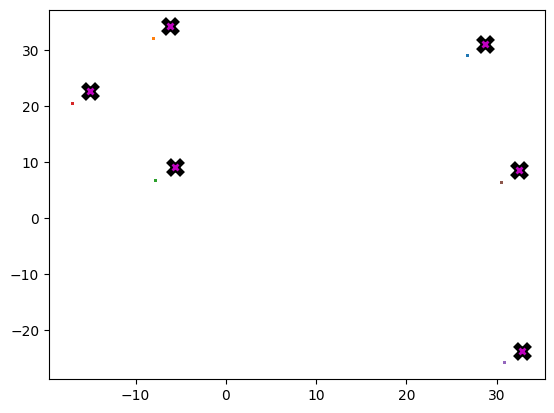

In [72]:
plot_data(centroids+2, X_v1.cpu(), labels)

## Exploiting the Gaussian

Gaussian is a function of (X^2). So exploiting this we can avoid computing the sqrt in the distance.
The other thing to exploit is that 

d = a-b
weights = gaussian(lenght(d))
        = gaussian2(dot(d,d))

Where `gaussian2` is a gaussian that takes X^2 as input.

In [73]:
# sample values to use in tests
va = torch.Tensor(torch.randn([1000,2])).cuda()
vb = va[0]
va.shape, vb.shape

(torch.Size([1000, 2]), torch.Size([2]))

Measure performance of various implementations and ensuring all of them get to the same result.

In [74]:
d = va-vb
t_dists_v1 = (d*d).sum(1).sqrt()
t_dists_v2 = torch.linalg.norm(d,dim=1)
t_dists2_v1 = torch.linalg.norm(d,dim=1).pow(2) # all distances squared from first point
t_dists2_v2 = (d*d).sum(1)
t_dists2_v3 = torch.einsum('ij,ij->i',d,d)

torch.testing.assert_close(t_dists_v1,t_dists_v2)
torch.testing.assert_close(t_dists2_v1,t_dists2_v2)
torch.testing.assert_close(t_dists2_v1,t_dists2_v3)

Two different way to compute lenght

In [75]:
%timeit -n 100 (d*d).sum(1).sqrt()

7.18 µs ± 329 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
%timeit -n 100 torch.linalg.norm(d,dim=1) # using torch norm is way faster

3.04 µs ± 432 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


Two different way to compute squared lenght

In [77]:
%timeit -n 100 torch.linalg.norm(d,dim=1).pow(2)

5.63 µs ± 404 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
%timeit -n 100 torch.einsum('ij,ij->i',d,d)

7.75 µs ± 427 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
%timeit -n 100 (d*d).sum(1) # this is the winner

5.07 µs ± 395 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
def gaussian2(d2, bw): 
    # not sure python nor torch "compiler" will spot this
    bw2 = bw*bw
    return torch.exp(-0.5*((d2/bw2))) / (bw*math.sqrt(2*math.pi))

g1 = gaussian(t_dists_v1,bw=2.5)
g2 = gaussian2(t_dists2_v1, bw=2.5)
torch.testing.assert_close(g1,g2) # ensure results are the same

In [81]:
%timeit -n 100 gaussian(torch.linalg.norm(d,dim=1),bw=2.5) # Faster distance with gaussian

16.3 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%timeit -n 100 gaussian2((d*d).sum(1),bw=2.5) # gaussian2 and square distance

15.7 µs ± 835 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


Yes avoiding the pair sqrt and square, we can squeeze a little bit of performance

In [83]:
d.shape, (d*d).sum(1).shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [84]:
def batch_meanshift_step_v2(b,X,bw=2.5):
    d = X[None,:,:] - b[:,None,:] # differences
    weights = gaussian2((d*d).sum(-1), bw=bw)
    div = weights.sum(1, keepdim=True) # batchwise sum of weights
    return weights@X/div # weighted average
    
batch_meanshift_step_v2(b,data.clone()).shape

torch.Size([500, 2])

In [85]:
def meanshift_v2(data,bs=500,steps=5,bw=2.5):
    X = data.clone()
    for step in range(steps):
        X = torch.concat( # concat and update
            [
                batch_meanshift_step_v2(b,X,bw=bw)
                for b in X.split(bs) # batchify X
            ]
        )
    return X

X_v1 = meanshift_v2(data)

torch.testing.assert_close(meanshift_v1(data),meanshift_v2(data)) # ensure it has the same result

In [86]:
%timeit -n 100 meanshift(data)

2.09 ms ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%timeit -n 100 meanshift_v1(data) # Fastest one

1.72 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
%timeit -n 100 meanshift_v2(data)

1.91 ms ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


What a shame, despite the version v2 that avoids some operations works slightly faster batchwise, used in the complete loop leads to slower execution: a big effort for nothing or do we have a bug? ;-)

**...That's research!**